Create a Mario environment

In [12]:
# import the game
import gym_super_mario_bros
# Joypad wrapper
from nes_py.wrappers import JoypadSpace
# import simplified actions
from gym_super_mario_bros.actions import RIGHT_ONLY
from core.env_wrapper import SkipFrame, ResizeObservation
from gym.wrappers import GrayScaleObservation, TransformObservation, FrameStack


def make_mario(env_name: str):
    env = gym_super_mario_bros.make(env_name)
    env = JoypadSpace(env, RIGHT_ONLY)
    env = SkipFrame(env, skip=4)
    env = GrayScaleObservation(env, keep_dim=False)
    env = ResizeObservation(env, shape=84)
    env = TransformObservation(env, f = lambda x: x / 255.)
    env = FrameStack(env, num_stack=4)
    return env
RIGHT_ONLY

[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]

In [13]:
temp_env = make_mario('SuperMarioBros-v0')
temp_env.reset()

In [14]:
temp_env.action_space.n

5

In [15]:
temp_env.observation().shape

(4, 84, 84)

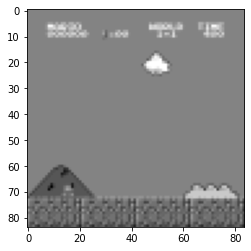

In [16]:
import matplotlib.pyplot as plt
plt.imshow(temp_env.observation()[0], cmap='gray')

Replay Buffer

In [17]:
from collections import deque, namedtuple
from typing import Tuple

from torch.utils.data.dataset import IterableDataset
import numpy as np

Experience = namedtuple("Experience",
                        field_names=['state', 'action', 'reward', 'done', 'new_state'],
                        )

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)
    
    def __len__(self):
        return len(self.buffer)
    
    def append(self, experience: Experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size: int) -> Tuple:
        # print(len(self.buffer), batch_size)
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*(self.buffer[idx] for idx in indices))
        
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool8),
            np.array(next_states),
        )

class RLDataset(IterableDataset):
    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200):
        self.buffer = buffer
        self.sample_size = sample_size
    
    def __iter__(self) -> Tuple:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i] 

Agent

In [18]:
from typing import Tuple
import gym, torch
import numpy as np
from torch import nn
import wandb
# from .memory import ReplayBuffer, Experience
class Agent:
    def __init__(self, env: gym.Env, replay_buffer:ReplayBuffer) -> None:
        self.env = env
        self.replay_buffer = replay_buffer
        self.reset()
        self.state = self.env.reset()
    
    def reset(self):
        self.state = self.env.reset()
    
    def get_action(self, net:nn.Module, epsilon: float, device: str):
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])
            
            if device not in ['cpu']:
                state = state.cuda(device)
            
            q_value = net(state)
            _, action = torch.max(q_value, dim=1)
            action = int(action.item())
        
        return action
    
    @torch.no_grad()
    def play_step(self, net: nn.Module, epsilon: float = 0.0, device: str = "cpu") -> Tuple[float, bool]:
        action = self.get_action(net, epsilon, device)
        new_state, reward, done, _ = self.env.step(action)
        
        # self.env.render()
        # plt.close()
        # fig, ax = plt.subplots(1, 4)
        # plt.figure(figsize=(20,8))
        # for i in range(4):
        #     ax[i].imshow(self.state[i], cmap='gray')
                
        exp = Experience(self.state, action, reward, done, new_state)
        self.replay_buffer.append(exp)
        self.state = new_state
        if done:
            self.reset()
        
        return reward, done

Deep Q Network

In [19]:
class DQN(nn.Module):
    def __init__(self, obs_dim, n_actions):
        c, h, w = obs_dim
        
        if h != 84:
            raise ValueError(f"Expecting input height: 84, got: {h}")
        if w != 84:   
            raise ValueError(f"Expecting input width: 84, got: {w}")
        
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    def forward(self, state):
        # print(next(self.parameters()).is_cuda)
        return self.net(state.float())

Double DQN

In [20]:
from torch import Tensor
from typing import List, Tuple
import pytorch_lightning as pl
from torch.optim import Adam, Optimizer
from torch.utils.data.dataloader import DataLoader
from collections import OrderedDict
import torch.nn.functional as F

class DDQNLightning(pl.LightningModule):
    def __init__(
        self,
        batch_size: int = 32,
        lr: float = 0.00025,
        env: str = 'SuperMarioBros-v0',
        gamma: float = 0.9,
        sync_rate: int = 10000,
        replay_size: int = 100000,
        warm_start_size: int = 1000,
        eps_decay: int = 0.99999975,
        eps_start: float = 1.0,
        eps_min: float = 0.1,
        episode_length: int = 1000,
        warm_start_steps: int = 1000,
    ) -> None:
        super().__init__()
        
        self.save_hyperparameters()
        
        self.env = make_mario(env)
        self.env.reset()
        obs_dim = self.env.observation().shape
        n_actions = self.env.action_space.n
        
        self.net = DQN(obs_dim, n_actions)
        self.target_net = DQN(obs_dim, n_actions)
        
        self.buffer = ReplayBuffer(self.hparams.replay_size)
        self.agent = Agent(self.env, self.buffer)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.hparams.warm_start_steps)
    
    def populate(self, steps: int = 1000):
        for i in range(steps):
            print(f"warming up at step {i+1}", end='\r')
            self.agent.play_step(self.net, epsilon=1)
    
    def forward(self, state: Tensor):
        return self.net(state).float()
    
    def loss_fn(self, batch: Tuple[Tensor, Tensor]) -> Tensor:
        states, actions, rewards, dones, next_states = batch
        
        actions = actions.view(actions.size(0), 1)
        dones = dones.view(dones.size(0), 1)
        
        curr_Q = self.net(states).gather(1, actions)
        with torch.no_grad():
            next_Q = self.target_net(next_states)
            max_next_Q = next_Q.max(1)[0]
            max_next_Q = max_next_Q.view(max_next_Q.size(0), 1)
            
        expected_Q = (rewards + (1 - dones.float()) * self.hparams.gamma * max_next_Q)
        loss = F.mse_loss(curr_Q, expected_Q.detach())
        return loss
    
    def training_step(self, batch: Tuple[Tensor, Tensor], nb_batch) -> OrderedDict:
        device = self.get_device(batch)
        self.hparams.eps_start *= self.hparams.eps_decay
        epsilon = max(self.hparams.eps_min, self.hparams.eps_start)
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward
        loss = self.loss_fn(batch)
        
        if self.trainer.strategy in {"ddp", "dp"}:
            loss = loss.unsqueeze(0)
        
        if done:
            self.total_reward = self.episode_reward
            self.episode_reward = 0
            
        # Soft update of target network
        if self.global_step % self.hparams.sync_rate == 0:
            print("target net is synced")
            self.target_net.load_state_dict(self.net.state_dict())

        log = {
            "total_reward": torch.tensor(self.total_reward).to(device),
            "reward": torch.tensor(reward).to(device),
            "train_loss": loss,
        }
        status = {
            "steps": torch.tensor(self.global_step).to(device),
            "total_reward": torch.tensor(self.total_reward).to(device),
        }

        # self.log("my loss", loss, on_epoch=True)
        # self.log("reward", reward, on_epoch=True)
        # self.log("epsilon", epsilon, on_epoch=True)
        
        return OrderedDict({"loss": loss, "log": log, "progress_bar": status})
    
    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer."""
        optimizer = Adam(self.net.parameters(), lr=self.hparams.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences."""
        dataset = RLDataset(self.buffer, self.hparams.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader."""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch."""
        return batch[0].device.index if self.on_gpu else "cpu"

Start Training

In [21]:
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

model = DDQNLightning()
# wandb_logger = WandbLogger(name="qMario")
trainer = Trainer(
    accelerator="auto",
    devices = 1 if torch.cuda.is_available() else None,
    # logger=wandb_logger,
    max_epochs=10000,
    val_check_interval=50,
    # enable_progress_bar=False,
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 1.7 M 
1 | target_net | DQN  | 1.7 M 
------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.494    Total estimated model params size (MB)
/home/jimmy02119/anaconda3/envs/qmario/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


target net is synced0, ?it/s]True
Epoch 0: : 3it [00:00, 23.96it/s, loss=59.4, v_num=20]TrueTrue

/home/jimmy02119/anaconda3/envs/qmario/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1: : 0it [00:00, ?it/s, loss=54.9, v_num=20]    

/home/jimmy02119/anaconda3/envs/qmario/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Using a target size (torch.Size([4, 4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 99: : 4it [00:00, 32.53it/s, loss=18.8, v_num=20]rueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTrueTr